# Image Classifier 

In this notes we will study how to create an image classifier program using fast.ai.

We begin by importing all the required documentation. By importing fastbook from fastai we get access to all the standard methods and functions required to create the program.

In [1]:
# !pip install -Uqq fastbook # uncomment this line if installation of fastbook is needed.
from fastbook import *
from fastai.vision.widgets import *
setup_book()
home = os.getcwd() 
home, os.listdir(home) # checks local directory and subdirectories

('/notebooks/What_we_know_about_ML',
 ['Image_classifier.ipynb', '.ipynb_checkpoints'])

In [2]:
# uncomment to remove undesired directories completely
# to_delete_path = (Path(home)/"transports")
# try:
#    shutil.rmtree(to_delete_path)
# except OSError as e:
#    print("Error: %s : %s" % (to_delete_path, e.strerror))

### Obtaining the images

The first step to build an image classifier is to have access to a vast amount of data. In this case, since we are dealing with images, we will use [Microsoft Bing](https://www.bing.com/) which is a web search engine from Microsoft. To do so whithin python, we need acces to the browser trough the use of Bing Image Search API. This is achieved by the following function

In [3]:
def bing_search(subscription_key,search_term,count=150):
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    headers = {"Ocp-Apim-Subscription-Key" : subscription_key}
    params  = {"q": search_term, "license": "all", "imageType": "photo", "count": count}
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json()
    thumbnail_urls = [img["thumbnailUrl"] for img in search_results["value"]]
    return thumbnail_urls

The function downloads a bunch of images related to the word "search_term" (the results from here would be totally equivalent to the ones obtained by looking from the bing search page directly!) in the form of a list of URL linked to the images. It asks for a subscription key which can be obtained by singing up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account and looking for the Bing service. After this we are ready to look for images directly from here!

In [4]:
key = "e7f87f0369db4e9592d5ea7c38dfc059" # subscription key
category = "transports" # class characterizing all the objects
category_types = ['train','tram','bus'] # objects we want to indentify
path = Path(category) # creates a path related to the local directory
# the following lines create subdirectories for each object and download to them the repective images from the URL.
if not path.exists():
    path.mkdir()
    for obje in category_types:
        dest = (path/obje)
        dest.mkdir(exist_ok=True)
        results = bing_search(key,obje)
        download_images(dest, urls=results)

In [5]:
images = get_image_files(path) # stores the images from the path
len(images)

450

In [6]:
failed = verify_images(images) # checks zero size or damaged images and unlink them 
print(len(failed))
failed 
failed.map(Path.unlink);
print(len(images))

0
450


### Preparing the data

Once having all the data, we need to prepare it ready for trainning. To do so we use the `DataLoaders` class from fastai which organizes the files in a convenient way. In particular it will separate them into training and validation sets.
To turn our downloaded data into a `DataLoaders` object we need to tell fastai at least four things:

- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

Fastai has a flexible system called *data block API* with which you can fully customize every stage of the creation of your `DataLoaders` as follow:

In [7]:
data_setup = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

Let's analyze what each line does:

- blocks separates the data into independent and dependent variables. In this case our independent variables are images and the dependent ones are the categories_type (tram,train,bus,etc).
- get_items tells fastai how to obtain the data, in this case it is just building a list from a path trough the get_image_files function defined above.
- splitter explicits how to separate the data into validation and training sets. In this case we do it by a random split in which 20% of the data is saved for validation and the seed parameter assures that we get the same random split each time we run the notebook.
- get_y defines how to call read the labels of each dataset. In this case the function parent_label takes the label from the folder containing the image (i.e. images inside the "tram" folder will be labeled as trams.)
- item_tfms resize and reshape all the images to put all of them in the same format. In this case, all the images are resized and cropped randomly to squares of 224 x 224 pxs. Using this function has a lot of advantages compared to others like the standard resize, pad, etc.
- batch_tfms applies a function for each mini-batch completely. In this case we use aud_transforms to deform the images by rotating, stretching, flipping, etc. This is a particular case of *data augmentation* which creates random variations of our input data, such that they appear different, but do not actually change the meaning of the data.


In [8]:
data = data_setup.dataloaders(path)

Finally, with the data block setted up we create a dataloaders object which is the final form of our data, just ready to be used for training the machine!

### Training the machine

In order to train the machine to recognize images from our dataset we create the learner with the cnn_learner function. It takes the data, an architecture and the way of measuring the errors as parameters. In this case we use a resnet18 as architecture and we ask for the error_rate. Finally with fine_tune we train the machine specifying the number of epochs.

In [9]:
learner = cnn_learner(data, resnet18, metrics=error_rate)
learner.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.490590,0.427641,0.166667,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.761857,0.241477,0.077778,00:05
1,0.619647,0.152563,0.055556,00:05
2,0.480086,0.100914,0.044444,00:05
3,0.413262,0.073050,0.022222,00:05
4,0.362517,0.067977,0.033333,00:05


### Interpreting the results

By creating the following interpretator object we get acces a lot of ways of displaying the results of our trained model. In particular the confusion_matrix shows exactly in which cases our model fails and what is its prediction for them.

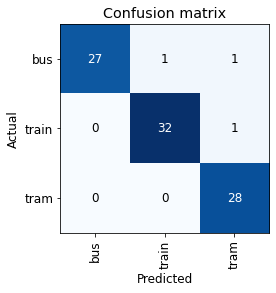

In [10]:
interpretator = ClassificationInterpretation.from_learner(learner)
interpretator.plot_confusion_matrix()

With plot_top_losses we see the images, the prediction, the label, for how much the model failed and/or how confident it is with that result, for the wrong classifications and the less confident ones.

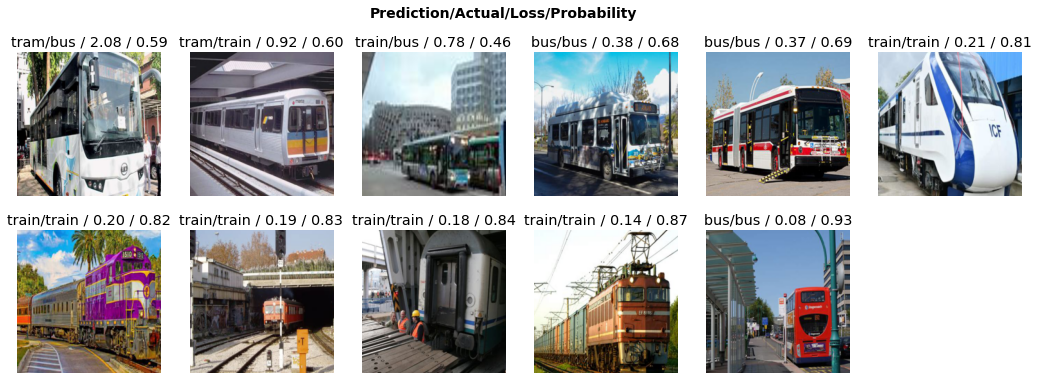

In [11]:
interpretator.plot_top_losses(11, nrows=2)

### Using the model for prediction

Now that we trained our model and interpretted the data, we are ready to use it on external sources. One way to do it is by uploading our own images and asking the machine what is its prediction about it.

In [12]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

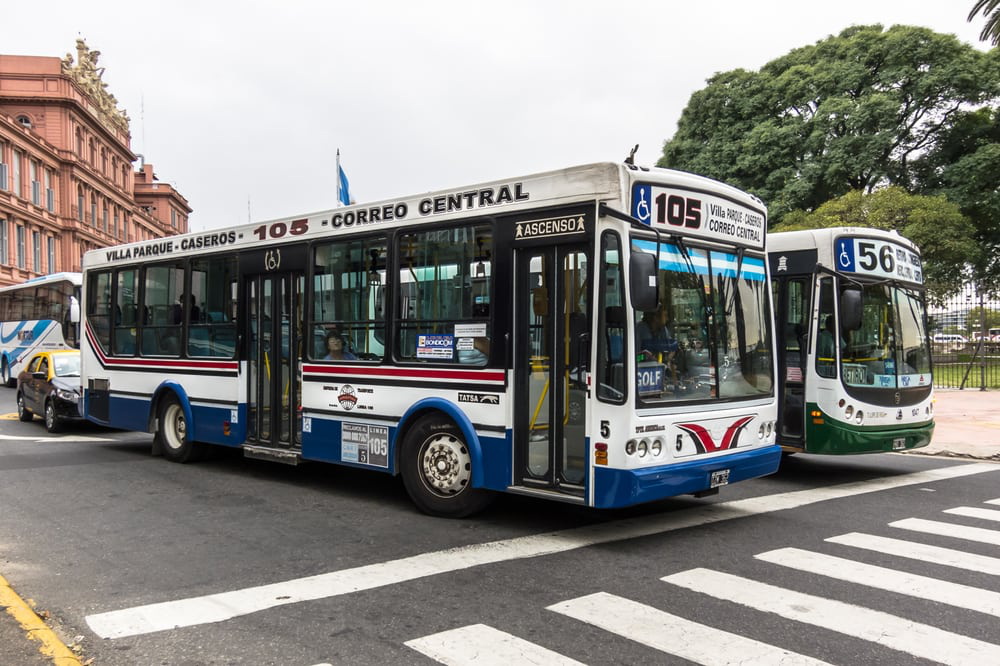

In [15]:
img = PILImage.create(uploader.data[0])
img

For each previous image we can see the model's prediction by calling the predict function.

In [16]:
learner.predict(img)

('bus', TensorImage(0), TensorImage([9.9816e-01, 2.4002e-08, 1.8427e-03]))